# Route Dominance Training DataFrame Creation

This notebook creates a comprehensive training DataFrame for route dominance prediction models.

## Overview

**Workflow:**
1. Configure which weeks to process
2. Load input, output, and supplementary data
3. Initialize Route Dominance Scorer
4. Process plays to calculate frame-by-frame metrics
5. Create training-ready DataFrame with all features
6. Analyze and visualize results

**Key Features:**
- Continuous frame numbering (varies by play, starts at 1)
- Throw status (pre-throw vs after-throw)
- Nearest defender coordinates (X, Y positions)
- Completion label (1 = Complete, 0 = Incomplete)
- All dominance metrics (separation, speed, acceleration, leverage angle, time advantage, etc.)
- Route-level aggregated scores
- Route break detection (break frame, frames until/since break, is_break_frame flag)


In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from route_dominance_scoring import RouteDominanceScorer
from interactive_route_dominance import InteractiveRouteDominanceViewer
try:
    from tqdm import tqdm
except ImportError:
    # Fallback if tqdm not available
    def tqdm(iterable, **kwargs):
        return iterable

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

print("✓ Libraries imported successfully")


✓ Libraries imported successfully


## 1. Configuration

Configure which weeks to process and preprocessing parameters.


In [2]:
# ============================================================================
# Configuration: Weeks to Process
# ============================================================================
# Options:
#   WEEKS_TO_PROCESS = None           → Process ALL weeks (1-18) - Full dataset
#   WEEKS_TO_PROCESS = [1]            → Process only week 1 - Quick testing
#   WEEKS_TO_PROCESS = [1, 2, 3]      → Process specific weeks
#   WEEKS_TO_PROCESS = list(range(1, 5)) → Process weeks 1-4

WEEKS_TO_PROCESS = [1]  # Set to None for all weeks

# ============================================================================
# Configuration: Preprocessing Parameters
# ============================================================================
THROWAWAY_DIST = 8.0  # yards; plays with dist_to_ball > this at arrival will be filtered
EXCLUDE_ROUTE_KEYWORDS = ["screen", "angle"]  # case-insensitive route exclusions

# Display configuration
print("="*80)
if WEEKS_TO_PROCESS is None:
    print("CONFIGURATION: Processing ALL WEEKS (1-18)")
else:
    print(f"CONFIGURATION: Processing WEEKS {WEEKS_TO_PROCESS}")
    print(f"  Total weeks: {len(WEEKS_TO_PROCESS)}")
    print(f"  Week range: {min(WEEKS_TO_PROCESS)} to {max(WEEKS_TO_PROCESS)}")
print(f"\nPreprocessing Settings:")
print(f"  THROWAWAY_DIST: {THROWAWAY_DIST} yards")
print(f"  EXCLUDE_ROUTE_KEYWORDS: {EXCLUDE_ROUTE_KEYWORDS}")
print("="*80)


CONFIGURATION: Processing WEEKS [1]
  Total weeks: 1
  Week range: 1 to 1

Preprocessing Settings:
  THROWAWAY_DIST: 8.0 yards
  EXCLUDE_ROUTE_KEYWORDS: ['screen', 'angle']


## 2. Data Loading

Load input (pre-throw), output (post-throw), and supplementary (play context) data.



In [3]:
# Helper functions to load data files
def load_all_input_files(data_dir="../data", weeks=None):
    """Load all input CSV files for specified weeks (default: all weeks 1-18)"""
    if weeks is None:
        weeks = list(range(1, 19))
    
    input_frames = []
    for w in weeks:
        fname = f"{data_dir}/input_2023_w{w:02d}.csv"
        try:
            df = pd.read_csv(fname)
            df["week"] = w
            input_frames.append(df)
            print(f"  ✓ Loaded input_2023_w{w:02d}.csv: {len(df):,} rows")
        except FileNotFoundError:
            print(f"  ⚠ Skipping missing file: {fname}")
        except Exception as e:
            print(f"  ✗ Error loading {fname}: {e}")
    
    if not input_frames:
        raise ValueError("No input files were loaded!")
    
    return pd.concat(input_frames, ignore_index=True)

def load_all_output_files(data_dir="../data", weeks=None):
    """Load all output CSV files for specified weeks (default: all weeks 1-18)"""
    if weeks is None:
        weeks = list(range(1, 19))
    
    output_frames = []
    for w in weeks:
        fname = f"{data_dir}/output_2023_w{w:02d}.csv"
        try:
            df = pd.read_csv(fname)
            df["week"] = w
            output_frames.append(df)
            print(f"  ✓ Loaded output_2023_w{w:02d}.csv: {len(df):,} rows")
        except FileNotFoundError:
            print(f"  ⚠ Skipping missing file: {fname}")
        except Exception as e:
            print(f"  ✗ Error loading {fname}: {e}")
    
    if not output_frames:
        raise ValueError("No output files were loaded!")
    
    return pd.concat(output_frames, ignore_index=True)

# Load data files
print("Loading data files...")
print("="*80)

# Load input data (pre-throw)
print("\nLoading INPUT data (pre-throw)...")
input_df = load_all_input_files(weeks=WEEKS_TO_PROCESS)
print(f"✓ Total input data: {len(input_df):,} rows")
print(f"  Unique plays: {input_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")
print(f"  Weeks: {sorted(input_df['week'].unique())}")

# Load output data (post-throw)
print("\nLoading OUTPUT data (post-throw)...")
output_df = load_all_output_files(weeks=WEEKS_TO_PROCESS)
print(f"✓ Total output data: {len(output_df):,} rows")
print(f"  Unique plays: {output_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")
print(f"  Weeks: {sorted(output_df['week'].unique())}")

# Load supplementary data (play context)
print("\nLoading SUPPLEMENTARY data...")
supp_df = pd.read_csv("../data/Supplementary.csv")
print(f"✓ Supplementary data: {len(supp_df):,} rows")
print(f"  Unique plays: {supp_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")

# Apply route-based exclusions (screens/angles) before scoring
print("\n" + "="*80)
print("APPLYING ROUTE FILTERING")
print("="*80)

if "route_of_targeted_receiver" in supp_df.columns:
    route_lower = supp_df["route_of_targeted_receiver"].fillna("").str.lower()
    keyword_pattern = "|".join(EXCLUDE_ROUTE_KEYWORDS)
    exclude_mask = route_lower.str.contains(keyword_pattern)
    excluded_plays = supp_df.loc[exclude_mask, ["game_id", "play_id"]].drop_duplicates()
    
    if not excluded_plays.empty:
        print(f"Excluding {len(excluded_plays)} plays matching keywords: {EXCLUDE_ROUTE_KEYWORDS}")
        
        # Filter supplementary data
        supp_df = supp_df.loc[~exclude_mask].reset_index(drop=True)
        
        # Filter input data
        input_df = input_df.merge(excluded_plays.assign(exclude=1), on=["game_id", "play_id"], how="left")
        input_df = input_df[input_df["exclude"].isna()].drop(columns=["exclude"])
        
        # Filter output data
        output_df = output_df.merge(excluded_plays.assign(exclude=1), on=["game_id", "play_id"], how="left")
        output_df = output_df[output_df["exclude"].isna()].drop(columns=["exclude"])
        
        print(f"✓ Filtered data: {len(supp_df):,} plays remaining")
    else:
        print("No plays excluded by route filter")
else:
    print("⚠ route_of_targeted_receiver not found; skipping route filter")

print("\n" + "="*80)
print("DATA LOADING COMPLETE")
print("="*80)


Loading data files...

Loading INPUT data (pre-throw)...
  ✓ Loaded input_2023_w01.csv: 285,714 rows
✓ Total input data: 285,714 rows
  Unique plays: 819
  Weeks: [1]

Loading OUTPUT data (post-throw)...
  ✓ Loaded output_2023_w01.csv: 32,088 rows
✓ Total output data: 32,088 rows
  Unique plays: 819
  Weeks: [1]

Loading SUPPLEMENTARY data...
✓ Supplementary data: 18,009 rows
  Unique plays: 18,009

APPLYING ROUTE FILTERING
Excluding 1073 plays matching keywords: ['screen', 'angle']
✓ Filtered data: 16,936 plays remaining

DATA LOADING COMPLETE


## 3. Route Break Detection

Detect route breaks (sharp turns) for targeted receivers using geometric analysis.


In [4]:
# Route break detection functions

def get_shortest_angle_diff(angle1, angle2):
    """Calculate the smallest difference between two angles in degrees (-180 to 180)"""
    return (angle2 - angle1 + 180) % 360 - 180

def standardize_coordinates(df):
    """Standardize tracking data coordinates (x, y) so all plays move Left-to-Right"""
    df = df.copy()
    df['std_x'] = df['x']
    df['std_y'] = df['y']
    
    # Flip logic for plays moving left
    mask_left = df['play_direction'] == 'left'
    df.loc[mask_left, 'std_x'] = 120 - df.loc[mask_left, 'x']
    df.loc[mask_left, 'std_y'] = 53.3 - df.loc[mask_left, 'y']
    
    return df

def find_break_geometric(group):
    """Detect route break frame using geometric analysis"""
    group = group.sort_values('frame_id').reset_index(drop=True)
    
    # Check for minimum required frames
    if len(group) < 7:
        return np.nan
    
    # Smooth the standardized path
    window = min(7, len(group) if len(group) % 2 != 0 else len(group) - 1)
    if window < 3:
        return np.nan
    
    sx_smooth = savgol_filter(group['std_x'], window, 2)
    sy_smooth = savgol_filter(group['std_y'], window, 2)
    
    # Calculate Velocity and Direction
    vx = np.diff(sx_smooth, prepend=sx_smooth[0])
    vy = np.diff(sy_smooth, prepend=sy_smooth[0])
    
    # Use smoothed speed for the mask
    speed_smooth = np.sqrt(vx**2 + vy**2)
    
    # Calculate angle of motion (heading)
    heading = np.degrees(np.arctan2(vx, vy))
    
    # Calculate Angular Velocity
    heading_diff = np.zeros_like(heading)
    for i in range(1, len(heading)):
        heading_diff[i] = get_shortest_angle_diff(heading[i-1], heading[i])
    
    # Define Curvature Metric
    curvature = np.abs(heading_diff)
    
    # Mask out slow/standing movements (speed < 0.1 yd/sec)
    moving_mask = speed_smooth > 0.1
    curvature[~moving_mask] = 0
    
    # Ignore the first 5 frames (Line-of-Scrimmage Movement / Release)
    search_start_index = 5
    
    # Find the Peak Break
    search_curvature = curvature[search_start_index:]
    if len(search_curvature) == 0:
        return np.nan
    
    # Find the index of max curvature within the search window
    relative_index = np.argmax(search_curvature)
    max_curve_index = relative_index + search_start_index
    max_curve_val = curvature[max_curve_index]
    
    # Threshold: Must be a sharp turn (> 8 degrees/frame)
    if max_curve_val < 8.0:
        return np.nan
    
    return group.loc[max_curve_index, 'frame_id']

# Apply route break detection
print("\n" + "="*80)
print("FEATURE GENERATION: DETECTING ROUTE BREAK FRAME")
print("="*80)

# Define the grouping keys
GROUP_KEYS = ['game_id', 'play_id', 'nfl_id']

# Standardize Coordinates in Input Data
input_df = standardize_coordinates(input_df)

# Apply the function to every unique targeted receiver
print("Starting route break detection using groupby().apply()...")

# Filter for Targeted Receivers and apply the function
route_break_frames = input_df[
    input_df['player_role'] == 'Targeted Receiver'
].groupby(GROUP_KEYS).apply(find_break_geometric).reset_index(name='play_break_frame')

# Merge the results back into the full tracking data
input_df = pd.merge(
    input_df, 
    route_break_frames, 
    on=GROUP_KEYS,
    how='left'
)

# Clean up standardization columns
input_df.drop(columns=['std_x', 'std_y'], inplace=True, errors='ignore')

print(f"✓ Route break detection complete.")
print(f"  {route_break_frames['play_break_frame'].notna().sum():,} breaks identified out of {len(route_break_frames):,} targeted receivers")
print(f"✓ 'play_break_frame' column added to input_df.")
print("="*80)



FEATURE GENERATION: DETECTING ROUTE BREAK FRAME
Starting route break detection using groupby().apply()...
✓ Route break detection complete.
  184 breaks identified out of 774 targeted receivers
✓ 'play_break_frame' column added to input_df.


## 3. Data Exploration

Quick exploration of the loaded data structure.


In [5]:
# Find plays with targeted receivers
targeted_plays = input_df[
    input_df["player_role"] == "Targeted Receiver"
][["game_id", "play_id", "nfl_id", "player_name"]].drop_duplicates()

print(f"Total plays with targeted receivers: {len(targeted_plays):,}")

# Frame count analysis
print("\n" + "="*80)
print("FRAME COUNT ANALYSIS")
print("="*80)

input_frame_counts = input_df.groupby(["game_id", "play_id"]).size()
output_frame_counts = output_df.groupby(["game_id", "play_id"]).size()

print(f"Input frames per play:")
print(f"  Average: {input_frame_counts.mean():.1f}")
print(f"  Min: {input_frame_counts.min()}, Max: {input_frame_counts.max()}")

print(f"\nOutput frames per play:")
print(f"  Average: {output_frame_counts.mean():.1f}")
print(f"  Min: {output_frame_counts.min()}, Max: {output_frame_counts.max()}")

# Completion status
print(f"\n" + "="*80)
print("COMPLETION STATUS")
print("="*80)
if "pass_result" in supp_df.columns:
    completion_counts = supp_df["pass_result"].value_counts()
    print(completion_counts)
    print(f"\nCompletion rate: {(completion_counts.get('C', 0) / len(supp_df) * 100):.1f}%")


Total plays with targeted receivers: 774

FRAME COUNT ANALYSIS
Input frames per play:
  Average: 347.5
  Min: 130, Max: 888

Output frames per play:
  Average: 40.4
  Min: 6, Max: 752

COMPLETION STATUS
pass_result
C     11575
I      4941
IN      420
Name: count, dtype: int64

Completion rate: 68.3%


## 4. Initialize Route Dominance Scorer

Initialize the scorer which combines input and output data and calculates motion features.


In [6]:
# Initialize the Route Dominance Scorer
print("Initializing Route Dominance Scorer...")
scorer = RouteDominanceScorer(input_df, output_df, supp_df)

print("✓ Route Dominance Scorer initialized")
print(f"  Combined frames: {len(scorer.all_frames_df):,} rows")
print(f"  Unique plays: {scorer.all_frames_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")


Initializing Route Dominance Scorer...
✓ Route Dominance Scorer initialized
  Combined frames: 300,261 rows
  Unique plays: 774


## 5. Process Plays and Create Training DataFrame

Process all plays to calculate frame-by-frame dominance metrics and create the training DataFrame.


In [7]:
# Function to create training DataFrame
def create_training_dataframe(input_df, output_df, supp_df, scorer, weeks=None, max_plays=None):
    """
    Create a training-ready DataFrame with all route dominance metrics
    
    Args:
        input_df: Input DataFrame (pre-throw data)
        output_df: Output DataFrame (post-throw data)
        supp_df: Supplementary DataFrame (play context)
        scorer: Initialized RouteDominanceScorer
        weeks: List of weeks to process (None = all weeks)
        max_plays: Maximum number of plays to process (None = all plays)
    
    Returns:
        DataFrame with all metrics for model training
    """
    print("="*80)
    print("PROCESSING PLAYS")
    print("="*80)
    
    # Get all unique plays with targeted receivers
    targeted_plays = input_df[
        input_df["player_role"] == "Targeted Receiver"
    ][["game_id", "play_id", "nfl_id", "player_name", "week"]].drop_duplicates()
    
    if weeks is not None:
        targeted_plays = targeted_plays[targeted_plays["week"].isin(weeks)]
    
    if max_plays is not None:
        targeted_plays = targeted_plays.head(max_plays)
    
    targeted_plays = targeted_plays[["game_id", "play_id", "nfl_id", "player_name"]]
    
    print(f"Processing {len(targeted_plays)} plays...")
    if len(targeted_plays) == 0:
        print("⚠ WARNING: No plays found!")
        return pd.DataFrame(), []
    
    all_metrics = []
    errors = []
    
    for idx, row in tqdm(targeted_plays.iterrows(), total=len(targeted_plays), desc="Processing"):
        game_id = row["game_id"]
        play_id = row["play_id"]
        target_nfl_id = row["nfl_id"]
        target_name = row["player_name"]
        
        try:
            # Calculate frame-by-frame dominance
            frame_metrics = scorer.calculate_frame_dominance(game_id, play_id, target_nfl_id)
            
            # Get play context from supplementary data
            supp_row = supp_df[
                (supp_df["game_id"] == game_id) &
                (supp_df["play_id"] == play_id)
            ]
            
            if not supp_row.empty:
                pass_result = supp_row.iloc[0].get("pass_result", "UNKNOWN")
                is_complete = 1 if pass_result == "C" else 0
                offense_formation = supp_row.iloc[0].get("offense_formation", "UNKNOWN")
                receiver_alignment = supp_row.iloc[0].get("receiver_alignment", "UNKNOWN")
                coverage_type = supp_row.iloc[0].get("team_coverage_type", "UNKNOWN")
                down = supp_row.iloc[0].get("down", np.nan)
                yards_to_go = supp_row.iloc[0].get("yards_to_go", np.nan)
                pass_length = supp_row.iloc[0].get("pass_length", np.nan)
                route = supp_row.iloc[0].get("route_of_targeted_receiver", "UNKNOWN")
            else:
                is_complete = np.nan
                offense_formation = "UNKNOWN"
                receiver_alignment = "UNKNOWN"
                coverage_type = "UNKNOWN"
                down = np.nan
                yards_to_go = np.nan
                pass_length = np.nan
                route = "UNKNOWN"
            
            # Add play-level context to each frame
            frame_metrics["target_name"] = target_name
            frame_metrics["is_complete"] = is_complete
            frame_metrics["offense_formation"] = offense_formation
            frame_metrics["receiver_alignment"] = receiver_alignment
            frame_metrics["coverage_type"] = coverage_type
            frame_metrics["down"] = down
            frame_metrics["yards_to_go"] = yards_to_go
            frame_metrics["pass_length"] = pass_length
            
            # Add continuous frame number (starts at 1, varies by play)
            frame_metrics["continuous_frame"] = range(1, len(frame_metrics) + 1)
            
            # Add throw_status column
            frame_metrics["throw_status"] = frame_metrics["frame_type"].map({
                "input": "pre_throw",
                "output": "after_throw"
            })
            
            # Add route break frame features
            # Get break frame for this play from input_df
            break_frame_info = input_df[
                (input_df["game_id"] == game_id) &
                (input_df["play_id"] == play_id) &
                (input_df["nfl_id"] == target_nfl_id)
            ][["play_break_frame"]].drop_duplicates()
            
            if not break_frame_info.empty and not pd.isna(break_frame_info.iloc[0]["play_break_frame"]):
                play_break_frame = break_frame_info.iloc[0]["play_break_frame"]
                has_break = True
                
                # Find which frames are input frames (pre-throw) to map break frame correctly
                input_frames = frame_metrics[frame_metrics["frame_type"] == "input"]
                
                if not input_frames.empty and play_break_frame in input_frames["frame_id"].values:
                    # Break frame is in the input (pre-throw) frames
                    # Map it to continuous frame number
                    break_row = input_frames[input_frames["frame_id"] == play_break_frame]
                    if not break_row.empty:
                        break_continuous_frame = break_row.iloc[0]["continuous_frame"]
                    else:
                        break_continuous_frame = np.nan
                else:
                    # Break frame not found in this play's frames
                    break_continuous_frame = np.nan
            else:
                play_break_frame = np.nan
                has_break = False
                break_continuous_frame = np.nan
            
            # Add break-related features to each frame
            frame_metrics["play_break_frame"] = play_break_frame
            frame_metrics["has_break"] = has_break
            
            # Calculate frame position relative to break
            if has_break and not pd.isna(break_continuous_frame):
                frame_metrics["is_break_frame"] = (frame_metrics["continuous_frame"] == break_continuous_frame).astype(int)
                frame_metrics["frames_until_break"] = break_continuous_frame - frame_metrics["continuous_frame"]
                frame_metrics["frames_since_break"] = frame_metrics["continuous_frame"] - break_continuous_frame
                # Set frames_since_break to NaN for frames before the break
                frame_metrics.loc[frame_metrics["frames_since_break"] < 0, "frames_since_break"] = np.nan
            else:
                frame_metrics["is_break_frame"] = 0
                frame_metrics["frames_until_break"] = np.nan
                frame_metrics["frames_since_break"] = np.nan
            
            # Get nearest defender coordinates for each frame
            nearest_def_x = []
            nearest_def_y = []
            receiver_x = []
            receiver_y = []
            
            for _, frame_row in frame_metrics.iterrows():
                frame_id = frame_row["frame_id"]
                frame_type = frame_row["frame_type"]
                
                play_frames = scorer.all_frames_df[
                    (scorer.all_frames_df["game_id"] == game_id) &
                    (scorer.all_frames_df["play_id"] == play_id) &
                    (scorer.all_frames_df["frame_id"] == frame_id) &
                    (scorer.all_frames_df["frame_type"] == frame_type)
                ]
                
                defenders = play_frames[play_frames["player_side"] == "Defense"]
                
                if not defenders.empty and not np.isnan(frame_row["sep_nearest"]) and frame_row["sep_nearest"] < np.inf:
                    receiver_frame = play_frames[play_frames["nfl_id"] == target_nfl_id]
                    if not receiver_frame.empty:
                        rec_x = receiver_frame.iloc[0]["x_std"]
                        rec_y = receiver_frame.iloc[0]["y_std"]
                        
                        def_dists = np.sqrt(
                            (defenders["x_std"] - rec_x)**2 +
                            (defenders["y_std"] - rec_y)**2
                        )
                        nearest_idx = def_dists.idxmin()
                        nearest_def = defenders.loc[nearest_idx]
                        nearest_def_x.append(nearest_def["x_std"])
                        nearest_def_y.append(nearest_def["y_std"])
                        receiver_x.append(rec_x)
                        receiver_y.append(rec_y)
                    else:
                        nearest_def_x.append(np.nan)
                        nearest_def_y.append(np.nan)
                        receiver_x.append(np.nan)
                        receiver_y.append(np.nan)
                else:
                    nearest_def_x.append(np.nan)
                    nearest_def_y.append(np.nan)
                    receiver_x.append(np.nan)
                    receiver_y.append(np.nan)
            
            frame_metrics["nearest_defender_x"] = nearest_def_x
            frame_metrics["nearest_defender_y"] = nearest_def_y
            frame_metrics["receiver_x"] = receiver_x
            frame_metrics["receiver_y"] = receiver_y
            
            # Calculate absolute horizontal and vertical difference to nearest defender
            frame_metrics["abs_dx_to_nearest_defender"] = (frame_metrics["receiver_x"] - frame_metrics["nearest_defender_x"]).abs()
            frame_metrics["abs_dy_to_nearest_defender"] = (frame_metrics["receiver_y"] - frame_metrics["nearest_defender_y"]).abs()
            
            all_metrics.append(frame_metrics)
            
        except Exception as e:
            error_msg = f"{type(e).__name__}: {str(e)}"
            errors.append((game_id, play_id, error_msg))
            # Print first few errors for debugging
            if len(errors) <= 5:
                print(f"  ⚠ Error processing Game {game_id}, Play {play_id}: {error_msg}")
            continue
    
    if not all_metrics:
        print("\n⚠ WARNING: No metrics generated!")
        print(f"  Total plays processed: {len(targeted_plays)}")
        print(f"  Total errors: {len(errors)}")
        if errors:
            print("\n  First 5 errors:")
            for i, (gid, pid, err) in enumerate(errors[:5], 1):
                print(f"    {i}. Game {gid}, Play {pid}: {err}")
        return pd.DataFrame(), errors
    
    training_df = pd.concat(all_metrics, ignore_index=True)
    
    print(f"\n✓ Processing complete!")
    print(f"  Total rows: {len(training_df):,}")
    print(f"  Total plays: {training_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")
    print(f"  Errors: {len(errors)}")
    
    return training_df, errors

print("✓ Function defined")


✓ Function defined


In [8]:
# Create training DataFrame
training_df, errors = create_training_dataframe(
    input_df, output_df, supp_df, scorer, 
    weeks=WEEKS_TO_PROCESS,
    max_plays=None  # Set to a number like 100 for faster testing
)

# Check if training DataFrame was created successfully
if training_df.empty:
    print("\n" + "="*80)
    print("ERROR: Training DataFrame is empty!")
    print("="*80)
    print(f"Number of errors: {len(errors)}")
    if errors:
        print("\nSample errors:")
        for i, (gid, pid, err) in enumerate(errors[:5]):
            print(f"  {i+1}. Game {gid}, Play {pid}: {err}")
    print("\nPlease check:")
    print("  1. Are there targeted receivers in the input data?")
    print("  2. Are the game_id and play_id values matching between datasets?")
    print("  3. Check the error messages above for specific issues")
else:
    # Filter out throwaways (plays where ball was nowhere near the target receiver)
    print("\n" + "="*80)
    print("FILTERING THROWAWAYS")
    print("="*80)
    
    if "game_id" not in training_df.columns or "play_id" not in training_df.columns:
        print("ERROR: training_df missing required columns 'game_id' or 'play_id'")
        print(f"Available columns: {list(training_df.columns)}")
    elif "dist_to_ball" not in training_df.columns:
        print("ERROR: training_df missing 'dist_to_ball' column")
        print(f"Available columns: {list(training_df.columns)}")
    else:
        last_frames = training_df.groupby(["game_id", "play_id"]).last().reset_index()
        throwaway_mask = last_frames["dist_to_ball"] > THROWAWAY_DIST
        throwaway_plays = last_frames[throwaway_mask][["game_id", "play_id"]]
        
        print(f"Found {len(throwaway_plays)} plays with ball > {THROWAWAY_DIST} yards from receiver")
        print(f"Percentage: {100 * len(throwaway_plays) / len(last_frames):.1f}%")
        
        if len(throwaway_plays) > 0:
            training_df = training_df[
                ~training_df.set_index(["game_id", "play_id"]).index.isin(
                    throwaway_plays.set_index(["game_id", "play_id"]).index
                )
            ].reset_index(drop=True)
            print(f"\n✓ Filtered out {len(throwaway_plays)} throwaway plays")
            print(f"  Remaining plays: {training_df[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")
            print(f"  Remaining frames: {len(training_df):,}")
        else:
            print("\n✓ No throwaway plays found")


PROCESSING PLAYS
Processing 774 plays...


Processing: 100%|██████████| 774/774 [08:55<00:00,  1.45it/s]



✓ Processing complete!
  Total rows: 30,549
  Total plays: 774
  Errors: 0

FILTERING THROWAWAYS
Found 10 plays with ball > 8.0 yards from receiver
Percentage: 1.3%

✓ Filtered out 10 throwaway plays
  Remaining plays: 764
  Remaining frames: 30,104


## 6. Training DataFrame Summary

Examine the structure and contents of the created training DataFrame.


In [9]:
# Display training DataFrame summary
if 'training_df' not in globals() or training_df.empty:
    print("="*80)
    print("ERROR: training_df is not defined or is empty")
    print("="*80)
    print("Please run the cell that creates the training DataFrame first:")
    print("  - Cell that calls create_training_dataframe()")
    print("  - Make sure it completes successfully")
else:
    print("="*80)
    print("TRAINING DATAFRAME SUMMARY")
    print("="*80)
    print(f"Shape: {training_df.shape}")
    print(f"\nColumns ({len(training_df.columns)} total):")
    for i, col in enumerate(training_df.columns, 1):
        print(f"  {i:2d}. {col}")

    print(f"\n" + "="*80)
    print("SAMPLE DATA")
    print("="*80)
    display_cols = [
        "game_id", "play_id", "continuous_frame", "frame_type", "throw_status",
        "dominance_score", "is_complete", "sep_nearest", "receiver_speed",
        "leverage_angle", "nearest_defender_x", "nearest_defender_y"
    ]
    print(training_df[display_cols].head(15))

    # Frame count verification
    print("\n" + "="*80)
    print("FRAME COUNT VERIFICATION")
    print("="*80)
    frame_counts = training_df.groupby(["game_id", "play_id"]).size()
    print(f"Average frames per play: {frame_counts.mean():.1f}")
    print(f"Min frames: {frame_counts.min()}, Max frames: {frame_counts.max()}")

    # Throw status distribution
    print(f"\n" + "="*80)
    print("THROW STATUS DISTRIBUTION")
    print("="*80)
    print(training_df["throw_status"].value_counts())

    # Completion statistics
    print(f"\n" + "="*80)
    print("COMPLETION STATISTICS")
    print("="*80)
    print(f"Completion rate: {training_df['is_complete'].mean():.2%}")
    print(f"Complete plays: {training_df['is_complete'].sum():,}")
    print(f"Incomplete plays: {(~training_df['is_complete'].astype(bool)).sum():,}")

    # Metric statistics
    print(f"\n" + "="*80)
    print("METRIC STATISTICS")
    print("="*80)
    metric_cols = [
        "dominance_score", "sep_nearest", "receiver_speed", "receiver_accel",
        "leverage_angle", "time_advantage", "num_def_within_3"
    ]
    print(training_df[metric_cols].describe())


TRAINING DATAFRAME SUMMARY
Shape: (30104, 44)

Columns (44 total):
   1. game_id
   2. play_id
   3. nfl_id
   4. frame_id
   5. frame_type
   6. x
   7. y
   8. sep_nearest
   9. sep_second
  10. num_def_within_2
  11. num_def_within_3
  12. num_def_within_5
  13. receiver_speed
  14. receiver_accel
  15. dist_to_ball
  16. time_to_ball
  17. def_time_to_ball
  18. time_advantage
  19. leverage_angle
  20. initial_leverage
  21. dominance_score
  22. route
  23. pass_result
  24. target_name
  25. is_complete
  26. offense_formation
  27. receiver_alignment
  28. coverage_type
  29. down
  30. yards_to_go
  31. pass_length
  32. continuous_frame
  33. throw_status
  34. play_break_frame
  35. has_break
  36. is_break_frame
  37. frames_until_break
  38. frames_since_break
  39. nearest_defender_x
  40. nearest_defender_y
  41. receiver_x
  42. receiver_y
  43. abs_dx_to_nearest_defender
  44. abs_dy_to_nearest_defender

SAMPLE DATA
       game_id  play_id  continuous_frame frame_type 

In [10]:
print(training_df.head())


      game_id  play_id  nfl_id  frame_id frame_type      x      y  \
0  2023090700      101   44930         1      input  41.03  41.13   
1  2023090700      101   44930         2      input  41.03  41.13   
2  2023090700      101   44930         3      input  41.05  41.12   
3  2023090700      101   44930         4      input  41.07  41.10   
4  2023090700      101   44930         5      input  41.11  41.08   

   sep_nearest  sep_second  num_def_within_2  ...  has_break  is_break_frame  \
0     3.423814   13.359435                 0  ...      False               0   
1     3.511595   13.363476                 0  ...      False               0   
2     3.571064   13.353580                 0  ...      False               0   
3     3.620635   13.343826                 0  ...      False               0   
4     3.659030   13.320154                 0  ...      False               0   

   frames_until_break  frames_since_break  nearest_defender_x  \
0                 NaN                 N

In [11]:
# If you're referring to printing the DataFrame with all columns and rows visible,
# you can use pandas display options to show more data at once.
# For Jupyter, you can also use display() for a prettier output.

import pandas as pd
from IPython.display import display

# Set pandas options to display more rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)  # adjust as needed
pd.set_option('display.width', 1000)

# Display the DataFrame in a way that's easy to see in the notebook
display(training_df.head(50))  # Show first 50 rows; adjust as needed

# To reset settings later, use:
# pd.reset_option('display.max_columns')
# pd.reset_option('display.max_rows')


,game_id,play_id,nfl_id,frame_id,frame_type,x,y,sep_nearest,sep_second,num_def_within_2,num_def_within_3,num_def_within_5,receiver_speed,receiver_accel,dist_to_ball,time_to_ball,def_time_to_ball,time_advantage,leverage_angle,initial_leverage,dominance_score,route,pass_result,target_name,is_complete,offense_formation,receiver_alignment,coverage_type,down,yards_to_go,pass_length,continuous_frame,throw_status,play_break_frame,has_break,is_break_frame,frames_until_break,frames_since_break,nearest_defender_x,nearest_defender_y,receiver_x,receiver_y,abs_dx_to_nearest_defender,abs_dy_to_nearest_defender
0,2023090700,101,44930,1,input,41.03,41.13,3.423814,13.359435,0,0,1,0.000000,0.000000,25.449655,inf,39.252689,-inf,21.074223,0.2,0.373157,CORNER,I,Josh Reynolds,0,SHOTGUN,2x2,COVER_2_ZONE,3,3,22,1,pre_throw,NaN,False,0,NaN,NaN,44.42,41.61,41.03,41.13,3.39,0.48
1,2023090700,101,44930,2,input,41.03,41.13,3.511595,13.363476,0,0,1,0.000000,0.000000,25.449655,inf,44.495286,-inf,21.441645,NaN,0.375658,CORNER,I,Josh Reynolds,0,SHOTGUN,2x2,COVER_2_ZONE,3,3,22,2,pre_throw,NaN,False,0,NaN,NaN,44.51,41.60,41.03,41.13,3.48,0.47
2,2023090700,101,44930,3,input,41.05,41.12,3.571064,13.353580,0,0,1,0.020000,0.470000,25.437060,1569.217822,42.044441,-1527.173381,21.612098,NaN,0.297137,CORNER,I,Josh Reynolds,0,SHOTGUN,2x2,COVER_2_ZONE,3,3,22,3,pre_throw,NaN,False,0,NaN,NaN,44.59,41.59,41.05,41.12,3.54,0.47
3,2023090700,101,44930,4,input,41.07,41.10,3.620635,13.343826,0,0,1,0.180000,1.540000,25.429361,158.308401,40.094913,-118.213488,21.777548,NaN,0.323514,CORNER,I,Josh Reynolds,0,SHOTGUN,2x2,COVER_2_ZONE,3,3,22,4,pre_throw,NaN,False,0,NaN,NaN,44.66,41.57,41.07,41.10,3.59,0.47
4,2023090700,101,44930,5,input,41.11,41.08,3.659030,13.320154,0,0,1,0.570000,3.090000,25.404252,51.510641,28.796630,-22.714011,22.097542,NaN,0.362715,CORNER,I,Josh Reynolds,0,SHOTGUN,2x2,COVER_2_ZONE,3,3,22,5,pre_throw,NaN,False,0,NaN,NaN,44.74,41.54,41.11,41.08,3.63,0.46
5,2023090700,101,44930,6,input,41.20,41.04,3.647862,13.334215,0,0,1,1.150000,4.780000,25.345491,26.083411,23.939835,-2.143576,22.412085,NaN,0.375748,CORNER,I,Josh Reynolds,0,SHOTGUN,2x2,COVER_2_ZONE,3,3,22,6,pre_throw,NaN,False,0,NaN,NaN,44.82,41.49,41.20,41.04,3.62,0.45
6,2023090700,101,44930,7,input,41.33,40.97,3.620635,13.237315,0,0,1,1.710000,5.150000,25.267119,17.754211,19.622041,1.867830,22.322749,NaN,0.561646,CORNER,I,Josh Reynolds,0,SHOTGUN,2x2,COVER_2_ZONE,3,3,22,7,pre_throw,NaN,False,0,NaN,NaN,44.92,41.44,41.33,40.97,3.59,0.47
7,2023090700,101,44930,8,input,41.54,40.88,3.522854,13.067077,0,0,1,2.450000,5.560000,25.130219,12.679061,15.895892,3.216830,22.366267,NaN,0.581835,CORNER,I,Josh Reynolds,0,SHOTGUN,2x2,COVER_2_ZONE,3,3,22,8,pre_throw,NaN,False,0,NaN,NaN,45.03,41.36,41.54,40.88,3.49,0.48
8,2023090700,101,44930,9,input,41.79,40.77,3.405437,12.867187,0,0,1,3.060000,5.150000,24.970449,10.074657,13.360252,3.285594,22.431175,NaN,0.592679,CORNER,I,Josh Reynolds,0,SHOTGUN,2x2,COVER_2_ZONE,3,3,22,9,pre_throw,NaN,False,0,NaN,NaN,45.16,41.26,41.79,40.77,3.37,0.49
9,2023090700,101,44930,10,input,42.12,40.62,3.223864,12.587692,0,0,1,3.740000,5.090000,24.765087,8.075468,12.048517,3.973049,21.929956,NaN,0.603022,CORNER,I,Josh Reynolds,0,SHOTGUN,2x2,COVER_2_ZONE,3,3,22,10,pre_throw,NaN,False,0,NaN,NaN,45.30,41.15,42.12,40.62,3.18,0.53


In [12]:
# Find a play (game_id, play_id) that has a break (i.e., has_break == True at any frame for the play)
break_play = training_df.loc[training_df["has_break"] == True, ["game_id", "play_id"]].drop_duplicates()
if not break_play.empty:
    example_break_play = break_play.iloc[0]
    print(f"Found a play with a break: game_id={example_break_play['game_id']}, play_id={example_break_play['play_id']}")
    # Optionally, show rows from that play
    display(training_df[(training_df["game_id"] == example_break_play['game_id']) & 
                       (training_df["play_id"] == example_break_play['play_id'])])
else:
    print("No plays with a break were found in the dataset.")


Found a play with a break: game_id=2023090700, play_id=361


,game_id,play_id,nfl_id,frame_id,frame_type,x,y,sep_nearest,sep_second,num_def_within_2,num_def_within_3,num_def_within_5,receiver_speed,receiver_accel,dist_to_ball,time_to_ball,def_time_to_ball,time_advantage,leverage_angle,initial_leverage,dominance_score,route,pass_result,target_name,is_complete,offense_formation,receiver_alignment,coverage_type,down,yards_to_go,pass_length,continuous_frame,throw_status,play_break_frame,has_break,is_break_frame,frames_until_break,frames_since_break,nearest_defender_x,nearest_defender_y,receiver_x,receiver_y,abs_dx_to_nearest_defender,abs_dy_to_nearest_defender
72,2023090700,361,38696,1,input,20.65,37.90,10.776873,11.975329,0,0,0,0.070000,0.630000,12.527606,2.047160e+02,inf,inf,65.668242,0.666667,0.588899,HITCH,C,Marvin Jones,1,SHOTGUN,3x1,COVER_4_ZONE,3,7,5,1,pre_throw,45.0,True,0,44.0,NaN,27.56,29.63,20.65,37.90,6.91,8.27
73,2023090700,361,38696,2,input,20.67,37.91,10.822038,12.003420,0,0,0,0.230000,1.250000,12.509909,5.452341e+01,inf,inf,65.063072,NaN,0.604394,HITCH,C,Marvin Jones,1,SHOTGUN,3x1,COVER_4_ZONE,3,7,5,2,pre_throw,45.0,True,0,43.0,NaN,27.53,29.54,20.67,37.91,6.86,8.37
74,2023090700,361,38696,3,input,20.71,37.94,10.877504,12.031529,0,0,0,0.500000,1.870000,12.465541,2.495963e+01,inf,inf,64.312173,NaN,0.622243,HITCH,C,Marvin Jones,1,SHOTGUN,3x1,COVER_4_ZONE,3,7,5,3,pre_throw,45.0,True,0,42.0,NaN,27.51,29.45,20.71,37.94,6.80,8.49
75,2023090700,361,38696,4,input,20.77,37.97,10.940503,12.074916,0,0,0,0.790000,3.020000,12.412615,1.583291e+01,129.621343,113.788433,63.525066,NaN,0.740713,HITCH,C,Marvin Jones,1,SHOTGUN,3x1,COVER_4_ZONE,3,7,5,4,pre_throw,45.0,True,0,41.0,NaN,27.52,29.36,20.77,37.97,6.75,8.61
76,2023090700,361,38696,5,input,20.86,38.06,11.048185,12.184876,0,0,0,1.340000,4.100000,12.292763,9.649042e+00,57.708650,48.059608,62.432697,NaN,0.752177,HITCH,C,Marvin Jones,1,SHOTGUN,3x1,COVER_4_ZONE,3,7,5,5,pre_throw,45.0,True,0,40.0,NaN,27.54,29.26,20.86,38.06,6.68,8.80
77,2023090700,361,38696,6,input,20.98,38.20,11.201004,12.363309,0,0,0,1.930000,4.580000,12.115065,6.835665e+00,34.666191,27.830526,61.102341,NaN,0.764344,HITCH,C,Marvin Jones,1,SHOTGUN,3x1,COVER_4_ZONE,3,7,5,6,pre_throw,45.0,True,0,39.0,NaN,27.58,29.15,20.98,38.20,6.60,9.05
78,2023090700,361,38696,7,input,21.13,38.38,11.390610,12.274730,0,0,0,2.490000,4.390000,11.888688,5.315771e+00,25.553280,20.237509,59.629034,NaN,0.775716,HITCH,C,Marvin Jones,1,SHOTGUN,3x1,COVER_4_ZONE,3,7,5,7,pre_throw,45.0,True,0,38.0,NaN,27.65,29.04,21.13,38.38,6.52,9.34
79,2023090700,361,38696,8,input,21.32,38.62,11.623790,12.010699,0,0,0,3.100000,4.220000,11.591463,4.214951e+00,19.699664,15.484713,57.879972,NaN,0.787983,HITCH,C,Marvin Jones,1,SHOTGUN,3x1,COVER_4_ZONE,3,7,5,8,pre_throw,45.0,True,0,37.0,NaN,27.74,28.93,21.32,38.62,6.42,9.69
80,2023090700,361,38696,9,input,21.54,38.89,11.694020,11.880488,0,0,0,3.600000,3.790000,11.255119,3.536946e+00,inf,inf,81.015172,NaN,0.728513,HITCH,C,Marvin Jones,1,SHOTGUN,3x1,COVER_4_ZONE,3,7,5,9,pre_throw,45.0,True,0,36.0,NaN,32.84,35.88,21.54,38.89,11.30,3.01
81,2023090700,361,38696,10,input,21.79,39.19,11.353524,12.168028,0,0,0,4.040000,3.470000,10.880083,3.046814e+00,inf,inf,81.984623,NaN,0.739221,HITCH,C,Marvin Jones,1,SHOTGUN,3x1,COVER_4_ZONE,3,7,5,10,pre_throw,45.0,True,0,35.0,NaN,32.74,36.19,21.79,39.19,10.95,3.00


## 7. Exploratory Data Analysis and Visualizations

Visualize key relationships and distributions in the data.


In [13]:
# Create route-level data (one row per play) for EDA
route_level_df = training_df.groupby(["game_id", "play_id"]).agg({
    "dist_to_ball": "last",
    "sep_nearest": "last",
    "is_complete": "first",
    "route": "first",
    "dominance_score": "mean",
    "receiver_speed": "mean",
    "leverage_angle": "mean"
}).reset_index()

print(f"Route-level data: {route_level_df.shape[0]} plays, {route_level_df['route'].nunique()} unique routes")


Route-level data: 764 plays, 10 unique routes


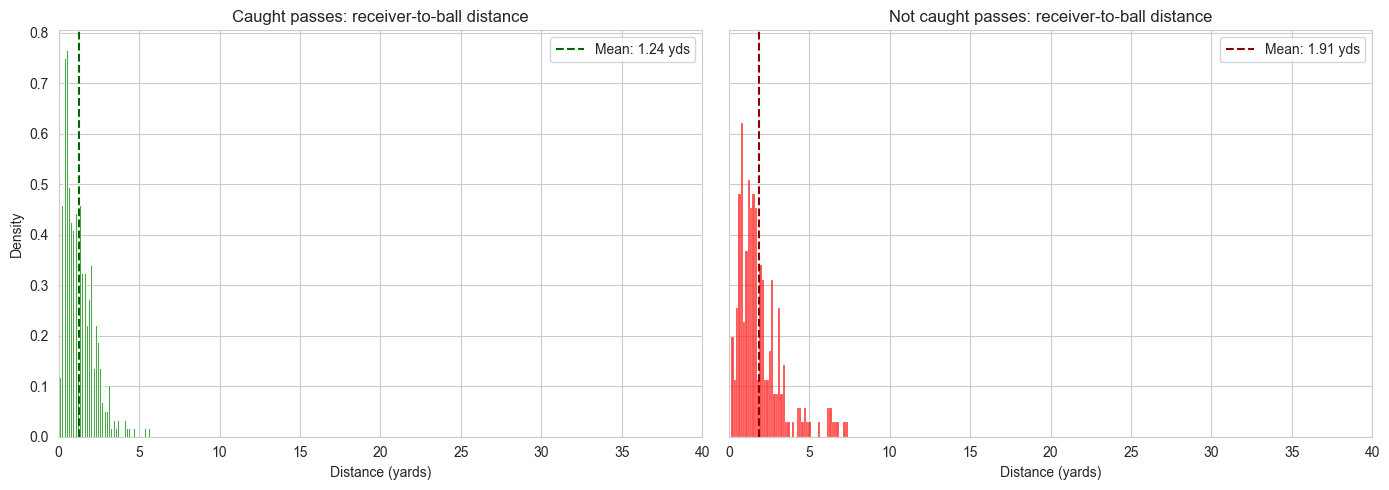

Mean distance (caught): 1.24 yards
Mean distance (not caught): 1.91 yards


In [14]:
# Plot 1: Distance to ball distribution - caught vs not caught
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

caught_mask = route_level_df["is_complete"] == 1
not_caught_mask = route_level_df["is_complete"] == 0

sns.histplot(
    route_level_df.loc[caught_mask, "dist_to_ball"],
    bins=50,
    stat="density",
    ax=axes[0],
    color="green",
    alpha=0.7
)
axes[0].set_xlim(0, 40)
axes[0].set_title("Caught passes: receiver-to-ball distance")
axes[0].set_xlabel("Distance (yards)")
axes[0].axvline(route_level_df.loc[caught_mask, "dist_to_ball"].mean(), 
                color="darkgreen", linestyle="--", 
                label=f"Mean: {route_level_df.loc[caught_mask, 'dist_to_ball'].mean():.2f} yds")
axes[0].legend()

sns.histplot(
    route_level_df.loc[not_caught_mask, "dist_to_ball"],
    bins=50,
    stat="density",
    ax=axes[1],
    color="red",
    alpha=0.7
)
axes[1].set_xlim(0, 40)
axes[1].set_title("Not caught passes: receiver-to-ball distance")
axes[1].set_xlabel("Distance (yards)")
axes[1].axvline(route_level_df.loc[not_caught_mask, "dist_to_ball"].mean(), 
                color="darkred", linestyle="--", 
                label=f"Mean: {route_level_df.loc[not_caught_mask, 'dist_to_ball'].mean():.2f} yds")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Mean distance (caught): {route_level_df.loc[caught_mask, 'dist_to_ball'].mean():.2f} yards")
print(f"Mean distance (not caught): {route_level_df.loc[not_caught_mask, 'dist_to_ball'].mean():.2f} yards")


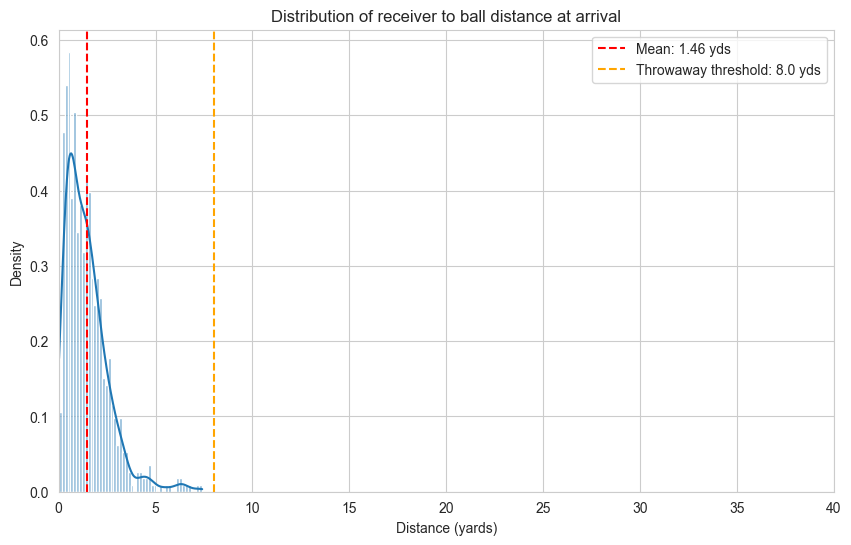

In [15]:
# Plot 2: Overall distance to ball distribution
plt.figure(figsize=(10, 6))
sns.histplot(route_level_df["dist_to_ball"], bins=50, stat="density", kde=True)
plt.axvline(route_level_df["dist_to_ball"].mean(), color="red", linestyle="--", 
            label=f"Mean: {route_level_df['dist_to_ball'].mean():.2f} yds")
plt.axvline(THROWAWAY_DIST, color="orange", linestyle="--", 
            label=f"Throwaway threshold: {THROWAWAY_DIST} yds")
plt.xlim(0, 40)
plt.title("Distribution of receiver to ball distance at arrival")
plt.xlabel("Distance (yards)")
plt.ylabel("Density")
plt.legend()
plt.show()


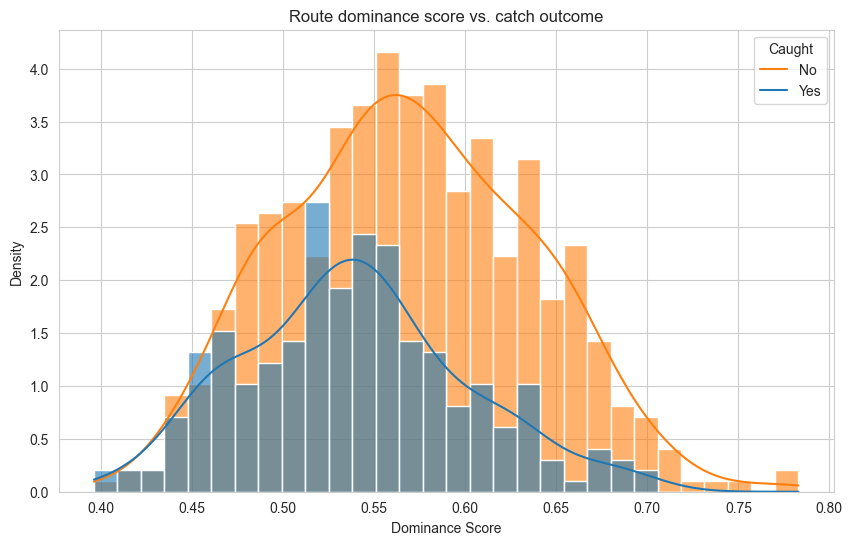

Mean dominance (caught): 0.568
Mean dominance (not caught): 0.539


In [16]:
# Plot 3: Dominance score distribution by completion outcome
plt.figure(figsize=(10, 6))
sns.histplot(
    data=route_level_df, 
    x="dominance_score", 
    hue="is_complete", 
    bins=30, 
    stat="density", 
    kde=True,
    alpha=0.6
)
plt.title("Route dominance score vs. catch outcome")
plt.xlabel("Dominance Score")
plt.ylabel("Density")
plt.legend(title="Caught", labels=["No", "Yes"])
plt.show()

caught_mask = route_level_df["is_complete"] == 1
print(f"Mean dominance (caught): {route_level_df.loc[caught_mask, 'dominance_score'].mean():.3f}")
print(f"Mean dominance (not caught): {route_level_df.loc[~caught_mask, 'dominance_score'].mean():.3f}")


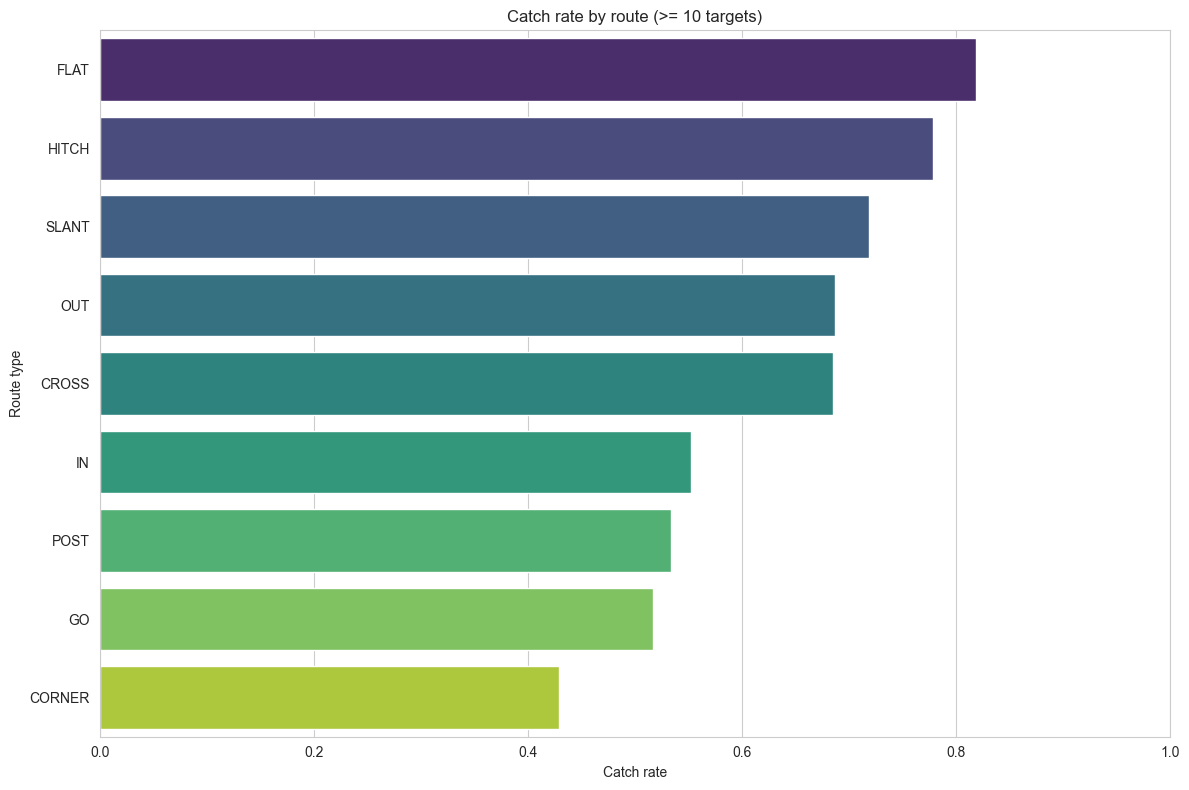


Top routes by catch rate:
    route      mean  count
2    FLAT  0.818182    121
4   HITCH  0.778571    140
8   SLANT  0.718310     71
6     OUT  0.687023    131
1   CROSS  0.685393     89
5      IN  0.552632     76
7    POST  0.533333     45
3      GO  0.516667     60
0  CORNER  0.428571     28


In [17]:
# Plot 4: Catch rate by route type
min_samples = 10
route_stats = route_level_df.groupby("route").agg({
    "is_complete": ["mean", "count"]
}).reset_index()
route_stats.columns = ["route", "mean", "count"]
route_stats = route_stats[route_stats["count"] >= min_samples].sort_values("mean", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=route_stats.head(20), x="mean", y="route", palette="viridis")
plt.title(f"Catch rate by route (>= {min_samples} targets)")
plt.xlabel("Catch rate")
plt.ylabel("Route type")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

print(f"\nTop routes by catch rate:")
print(route_stats.head(10))


In [18]:
# Compare completed vs incomplete plays
print("="*80)
print("COMPLETED VS INCOMPLETE COMPARISON")
print("="*80)

# Check if training_df exists
if 'training_df' not in globals() or (hasattr(training_df, 'empty') and training_df.empty):
    print("ERROR: training_df is not defined or is empty")
    print("Please run the cell that creates the training DataFrame first:")
    print("  - Look for the cell that calls: create_training_dataframe(...)")
    print("  - Make sure it completes successfully before running this cell")
else:
    metric_cols = [
        "dominance_score", "route_dominance_weighted", "sep_nearest",
        "receiver_speed", "leverage_angle", "time_advantage"
    ]
    
    # Check which columns exist (some may have been removed)
    available_cols = [col for col in metric_cols if col in training_df.columns]
    missing_cols = [col for col in metric_cols if col not in training_df.columns]
    
    if missing_cols:
        print(f"WARNING: Some columns not found: {missing_cols}")
        print(f"Using available columns: {available_cols}")
        metric_cols = available_cols
    
    if len(metric_cols) == 0:
        print("ERROR: None of the required metric columns found in training_df")
        print(f"Available columns: {list(training_df.columns)}")
    else:
        # Build aggregation dict with only available columns
        agg_dict = {}
        for col in metric_cols:
            if col == "route_dominance_weighted":
                agg_dict[col] = "first"
            else:
                agg_dict[col] = "mean"
        
        route_level = training_df.groupby(["game_id", "play_id", "is_complete"]).agg(agg_dict).reset_index()
        
        complete_stats = route_level[route_level["is_complete"] == 1][metric_cols].mean()
        incomplete_stats = route_level[route_level["is_complete"] == 0][metric_cols].mean()
        
        print("\nComplete Plays Statistics:")
        print(complete_stats)
        print("\nIncomplete Plays Statistics:")
        print(incomplete_stats)


COMPLETED VS INCOMPLETE COMPARISON
Using available columns: ['dominance_score', 'sep_nearest', 'receiver_speed', 'leverage_angle', 'time_advantage']

Complete Plays Statistics:
dominance_score     0.568352
sep_nearest              inf
receiver_speed      4.257664
leverage_angle     51.164772
time_advantage           NaN
dtype: float64

Incomplete Plays Statistics:
dominance_score     0.538680
sep_nearest              inf
receiver_speed      4.813152
leverage_angle     48.617166
time_advantage           NaN
dtype: float64


## 8. Save Training DataFrame

Save the processed DataFrame to CSV for model training.


In [19]:
# Save to CSV
output_file = "route_dominance_training_data.csv"
print(f"Saving training DataFrame to {output_file}...")
training_df.to_csv(output_file, index=False)
print(f"✓ Saved {len(training_df):,} rows to {output_file}")
file_size_mb = os.path.getsize(output_file) / (1024 * 1024)
print(f"  File size: {file_size_mb:.2f} MB")


Saving training DataFrame to route_dominance_training_data.csv...
✓ Saved 30,104 rows to route_dominance_training_data.csv
  File size: 10.02 MB


## 9. Interactive Visualization (Optional)

Use the interactive visualizer to explore plays frame-by-frame.


Creating interactive viewer for:
  Game ID: 2023090700
  Play ID: 101
  Targeted Receiver: Josh Reynolds (NFL ID: 44930)

Controls:
  Left Arrow  : Previous frame
  Right Arrow : Next frame
  Up Arrow    : Jump to first frame
  Down Arrow  : Jump to last frame
  'q' or Esc  : Quit

Click on the plot window and use arrow keys to navigate!
Calculating frame-by-frame dominance...

INTERACTIVE ROUTE DOMINANCE VIEWER
Controls:
  Left Arrow  : Previous frame
  Right Arrow : Next frame
  Up Arrow    : Jump to first frame
  Down Arrow  : Jump to last frame
  'q' or Esc  : Quit

Total frames: 47
Current frame: 1/47

Click on the plot window and use arrow keys to navigate!


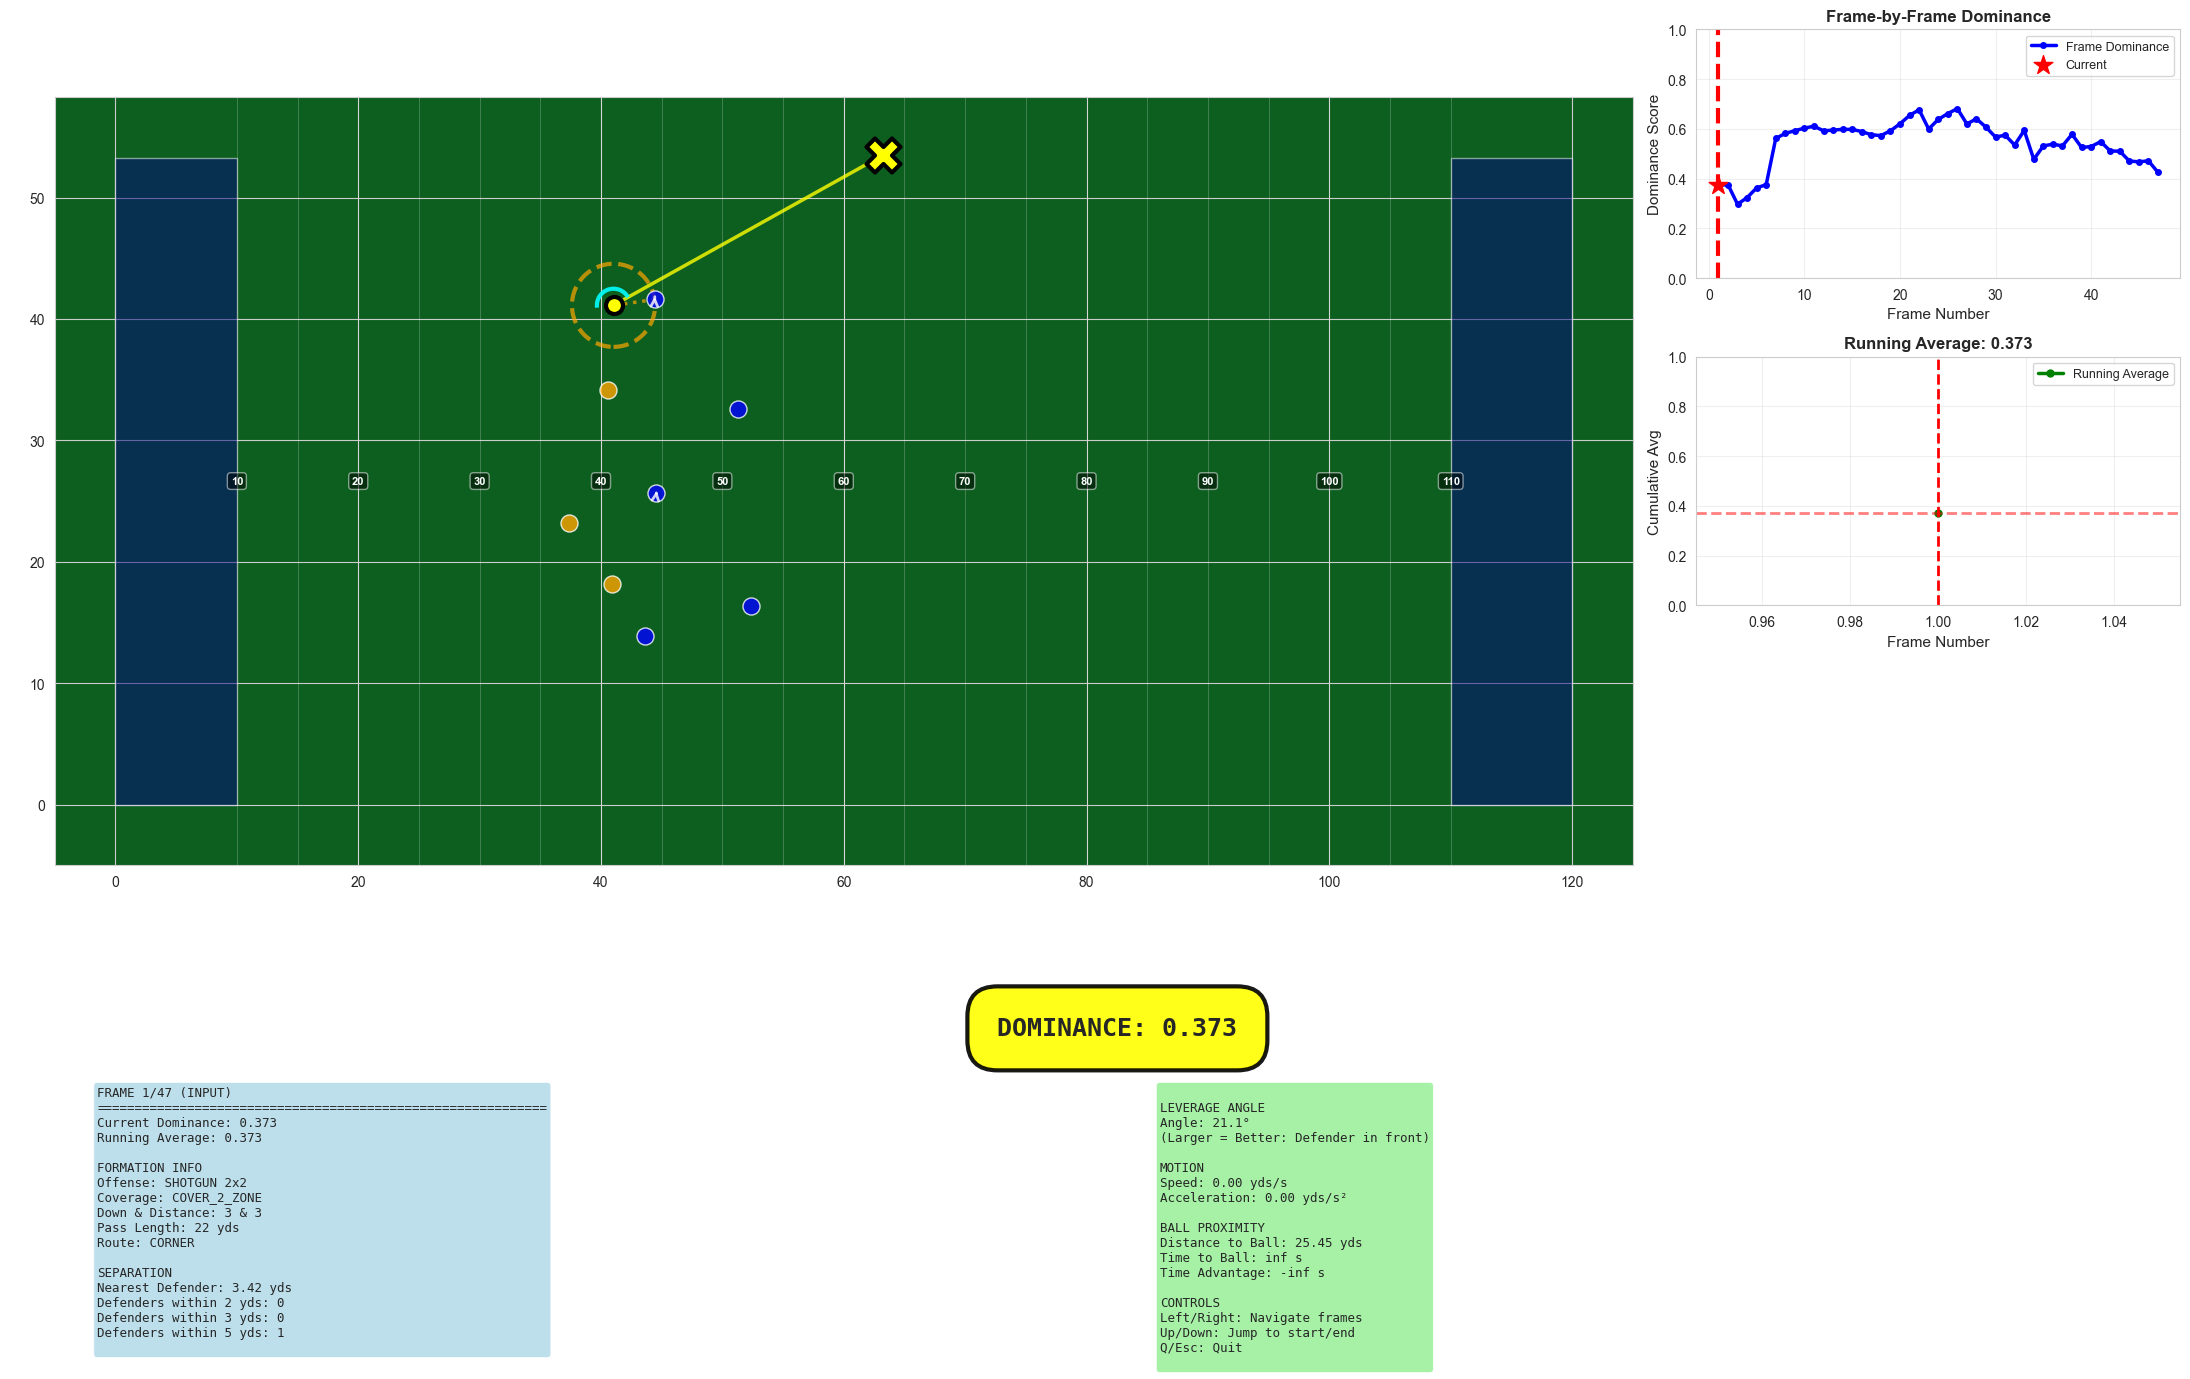

In [20]:
# Select an example play to visualize
example_game_id = 2023090700
example_play_id = 101

# Get targeted receiver for this play
target_info = input_df[
    (input_df["game_id"] == example_game_id) &
    (input_df["play_id"] == example_play_id) &
    (input_df["player_role"] == "Targeted Receiver")
]

if not target_info.empty:
    target_nfl_id = target_info["nfl_id"].iloc[0]
    target_name = target_info["player_name"].iloc[0]
    
    print(f"Creating interactive viewer for:")
    print(f"  Game ID: {example_game_id}")
    print(f"  Play ID: {example_play_id}")
    print(f"  Targeted Receiver: {target_name} (NFL ID: {target_nfl_id})")
    print("\nControls:")
    print("  Left Arrow  : Previous frame")
    print("  Right Arrow : Next frame")
    print("  Up Arrow    : Jump to first frame")
    print("  Down Arrow  : Jump to last frame")
    print("  'q' or Esc  : Quit")
    print("\nClick on the plot window and use arrow keys to navigate!")
    
    # Create interactive viewer
    viewer = InteractiveRouteDominanceViewer(scorer, example_game_id, example_play_id, target_nfl_id)
else:
    print(f"Targeted receiver not found for play {example_game_id}-{example_play_id}")


In [21]:
## Summary

The training DataFrame has been successfully created with:

✅ **Continuous frame numbering** - Variable frames per play, numbered sequentially from 1  
✅ **Throw status** - Distinguishes pre-throw vs after-throw frames  
✅ **Nearest defender coordinates** - X, Y positions of closest defender at each frame  
✅ **Completion label** - Binary target variable (1 = Complete, 0 = Incomplete)  
✅ **All dominance metrics** - Separation, speed, acceleration, leverage angle, time advantage, etc.  
✅ **Route-level scores** - Aggregated scores (average, weighted, max, min) across all frames  
✅ **Play context** - Formation, coverage, down, distance, route type  

The DataFrame is saved as `route_dominance_training_data.csv` and ready for model training!

### Next Steps

1. **Feature Engineering**: Create additional features from existing metrics
2. **Model Training**: Train LSTM, Transformer, or other sequential models on the frame sequences
3. **Validation**: Split data and evaluate model performance
4. **Analysis**: Explore which metrics are most predictive of completion


SyntaxError: invalid character '✅' (U+2705) (3166114805.py, line 5)

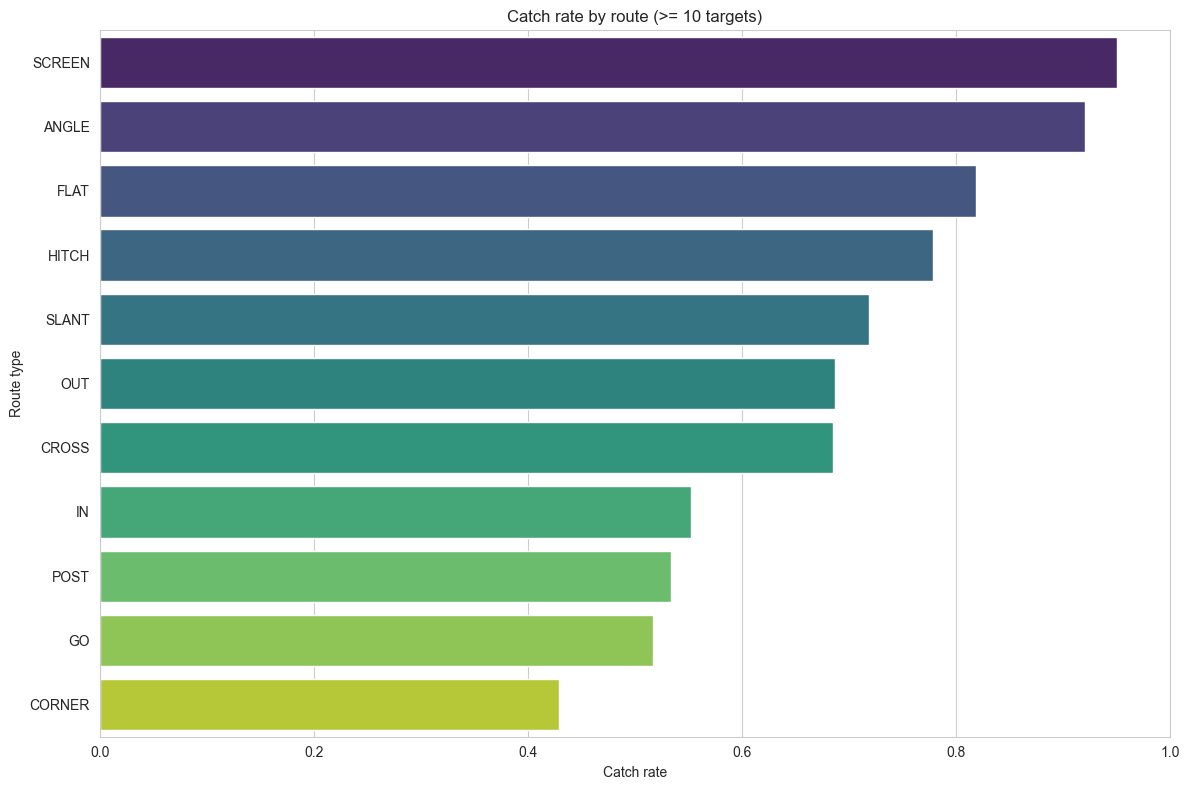


Top routes by catch rate:
     route      mean  count
9   SCREEN  0.950000     20
0    ANGLE  0.920000     25
3     FLAT  0.818182    121
5    HITCH  0.778571    140
10   SLANT  0.718310     71
7      OUT  0.687023    131
2    CROSS  0.685393     89
6       IN  0.552632     76
8     POST  0.533333     45
4       GO  0.516667     60


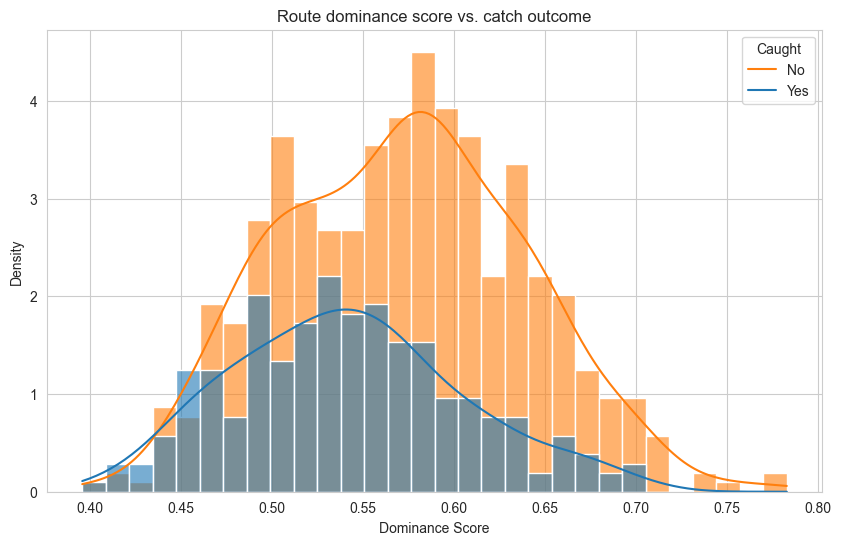

Mean dominance (caught): 0.572
Mean dominance (not caught): 0.541


Saving training DataFrame to route_dominance_training_data.csv...
✓ Saved 31,766 rows to route_dominance_training_data.csv


AttributeError: module 'pandas.io.common' has no attribute 'file_size'

Creating interactive viewer for:
  Game ID: 2023090700
  Play ID: 101
  Targeted Receiver: Josh Reynolds (NFL ID: 44930)

Controls:
  Left Arrow  : Previous frame
  Right Arrow : Next frame
  Up Arrow    : Jump to first frame
  Down Arrow  : Jump to last frame
  'q' or Esc  : Quit

Click on the plot window and use arrow keys to navigate!
Calculating frame-by-frame dominance...

INTERACTIVE ROUTE DOMINANCE VIEWER
Controls:
  Left Arrow  : Previous frame
  Right Arrow : Next frame
  Up Arrow    : Jump to first frame
  Down Arrow  : Jump to last frame
  'q' or Esc  : Quit

Total frames: 47
Current frame: 1/47

Click on the plot window and use arrow keys to navigate!


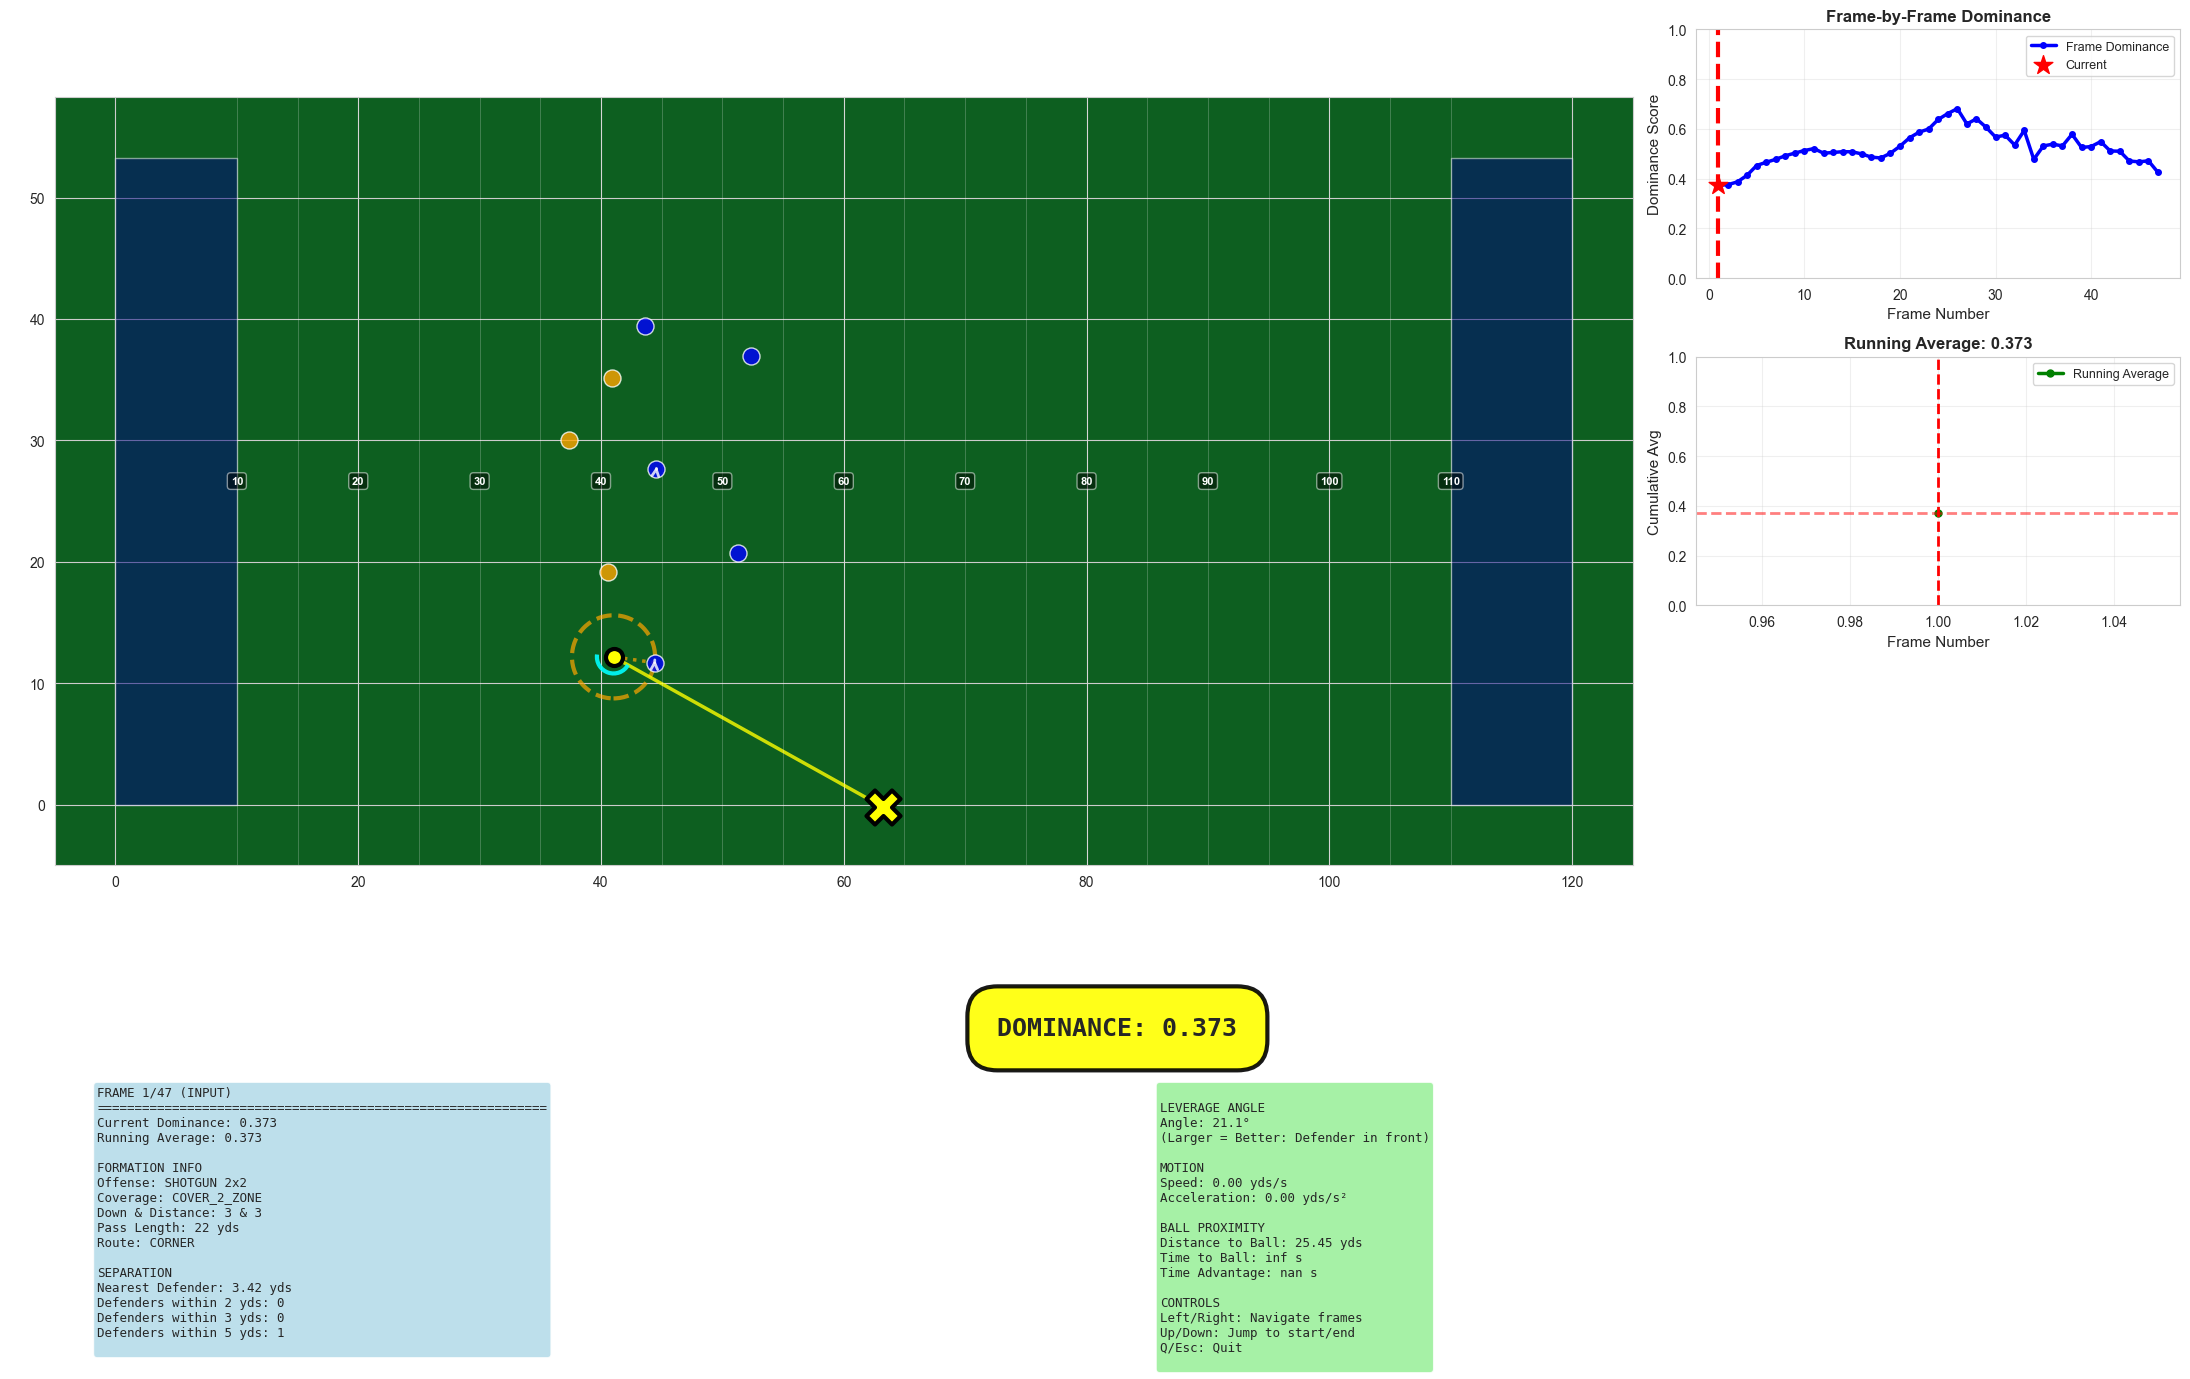

COMPLETED VS INCOMPLETE COMPARISON
                          Completed  Incomplete  Difference
dominance_score            0.571742    0.541491    0.030250
route_dominance_weighted   0.570146    0.538512    0.031634
sep_nearest                     inf         inf         NaN
receiver_speed             4.154415    4.798799   -0.644384
leverage_angle            50.915874   48.541106    2.374768
time_advantage                  NaN         NaN         NaN


## Summary

You now have a comprehensive training DataFrame with:

✅ **Continuous frame numbering** - Each play has variable numbers of frames (pre-throw + post-throw), numbered sequentially starting from 1  
✅ **Throw status** column - Distinguishes pre-throw vs after-throw frames  
✅ **Nearest defender coordinates** - X, Y positions of closest defender at each frame  
✅ **Completion label** - Binary target variable (1 = Complete, 0 = Incomplete)  
✅ **All dominance metrics** - Separation, speed, acceleration, leverage angle, time advantage, etc.  
✅ **Route-level scores** - Aggregated scores (average, weighted, max, min) across all frames  
✅ **Play context** - Formation, coverage, down, distance, route type  
✅ **All weeks processed** - Data from weeks 1-18 included  

The DataFrame is saved as `route_dominance_training_data.csv` and ready for model training!

### Next Steps

1. **Feature Engineering**: Create additional features from existing metrics
2. **Model Training**: Train LSTM, Transformer, or other sequential models on the frame sequences
3. **Validation**: Split data and evaluate model performance
4. **Analysis**: Explore which metrics are most predictive of completion
